In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import warnings
# Ignoring warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the dataset and displaying the first few rows
file_path = 'Data/loan_data.csv'
data = pd.read_csv(file_path)
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
# Displaying dataset information and unique values
print("\nDataset Info:")
data.info()

print("\nUnique Values in Categorical Columns:")
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].nunique()} unique values")
    print(f"Unique values in {col}: {data[col].unique()}")
    print("*******************************************************")



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_def

In [8]:
# Checking for missing and duplicate values
print("\nChecking for Missing and Duplicates:")
print("Missing values:", data.isnull().sum().sum())
print("Duplicate values:", data.duplicated().sum())


Checking for Missing and Duplicates:
Missing values: 0
Duplicate values: 0



Creating histograms and boxplots for numerical features


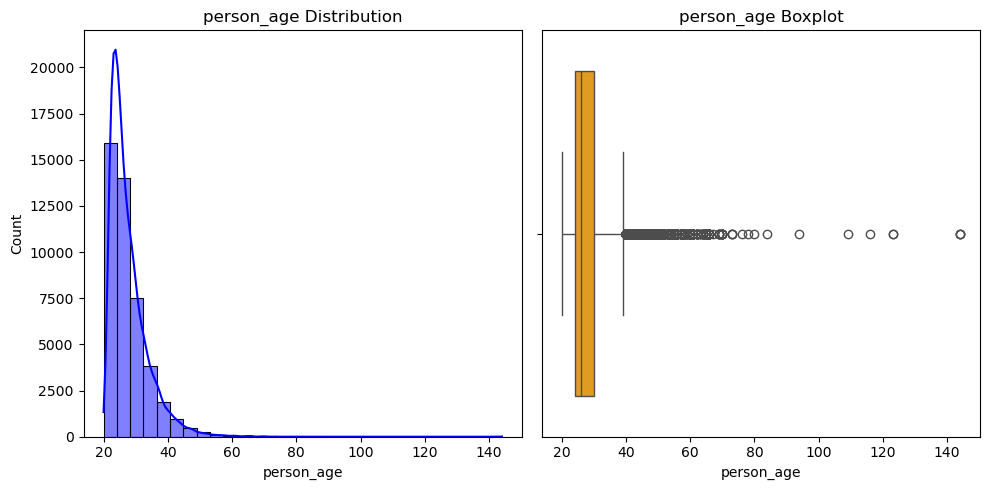

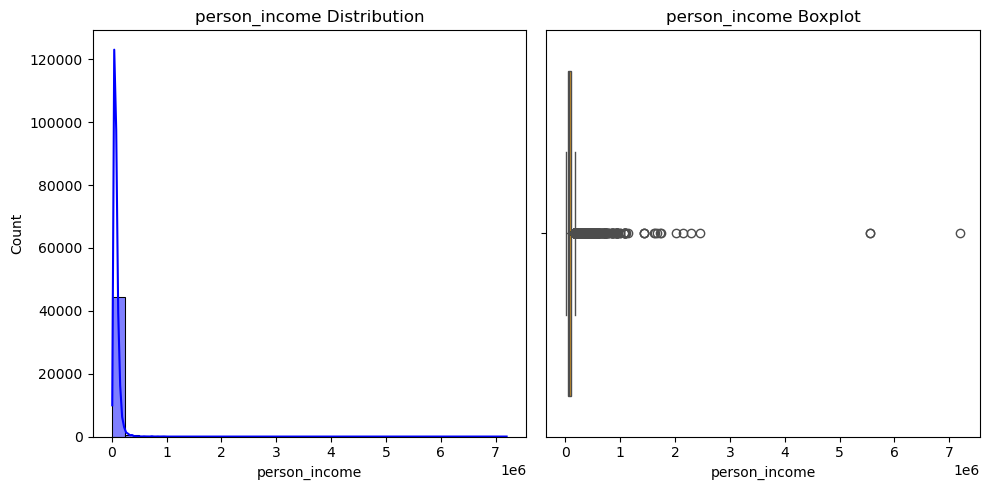

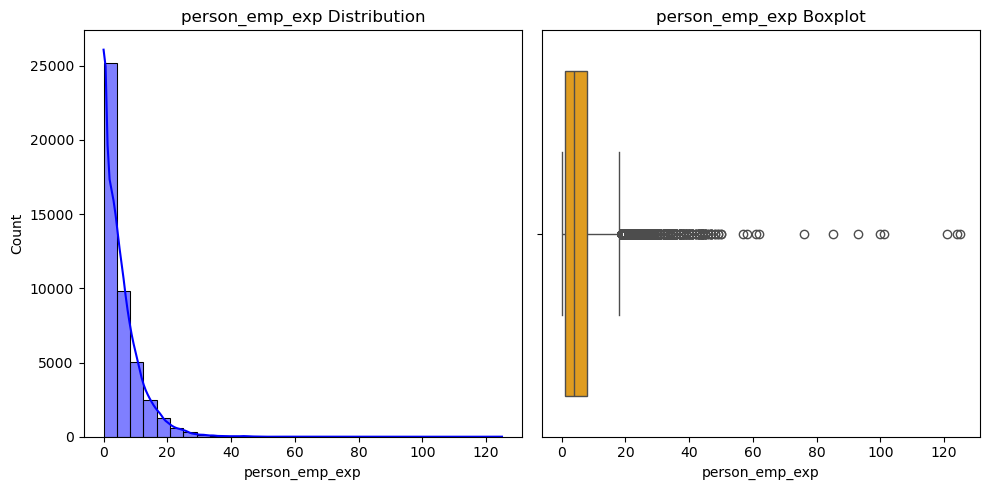

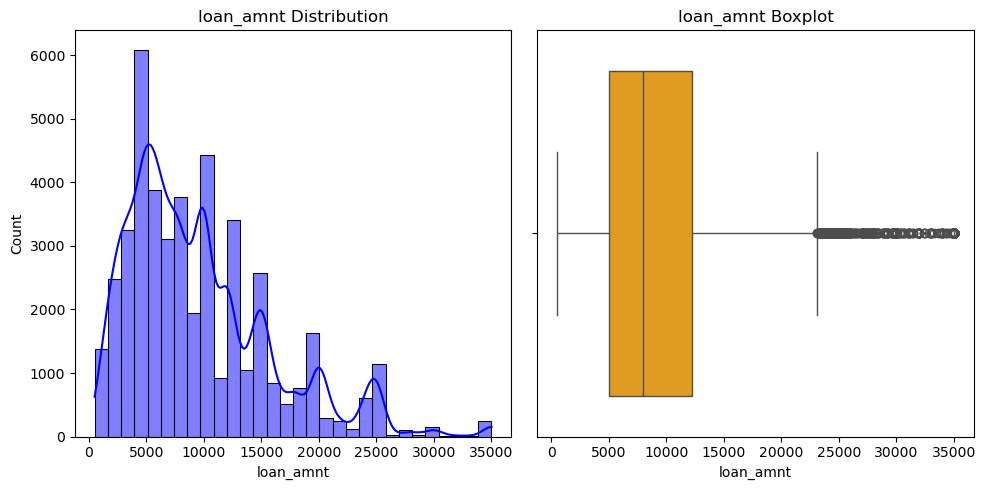

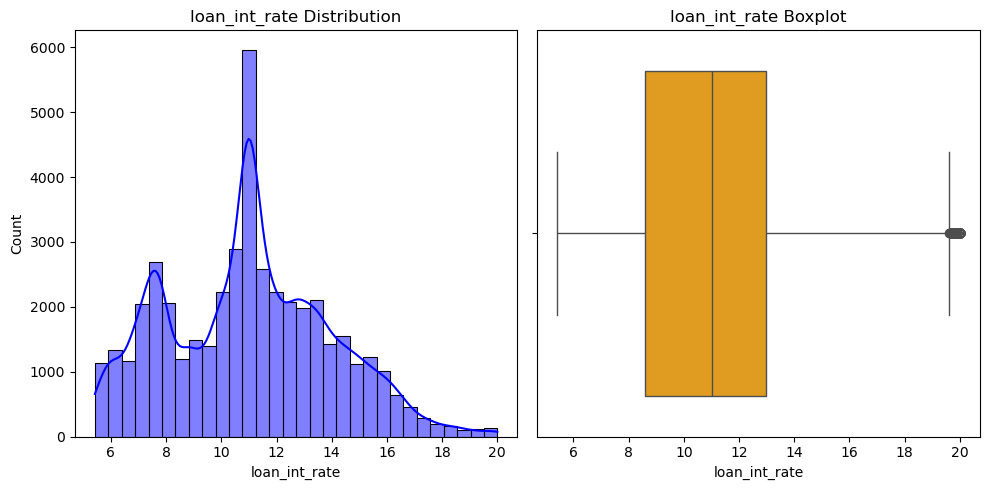

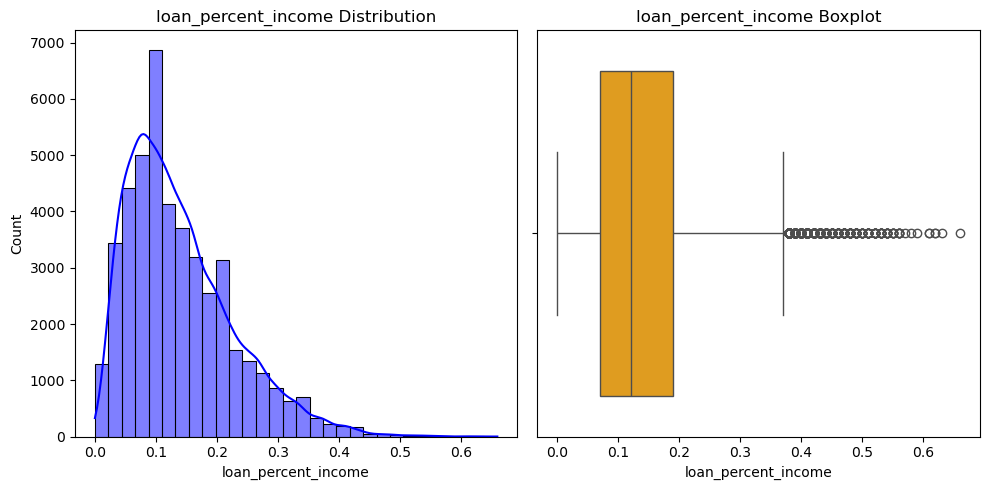

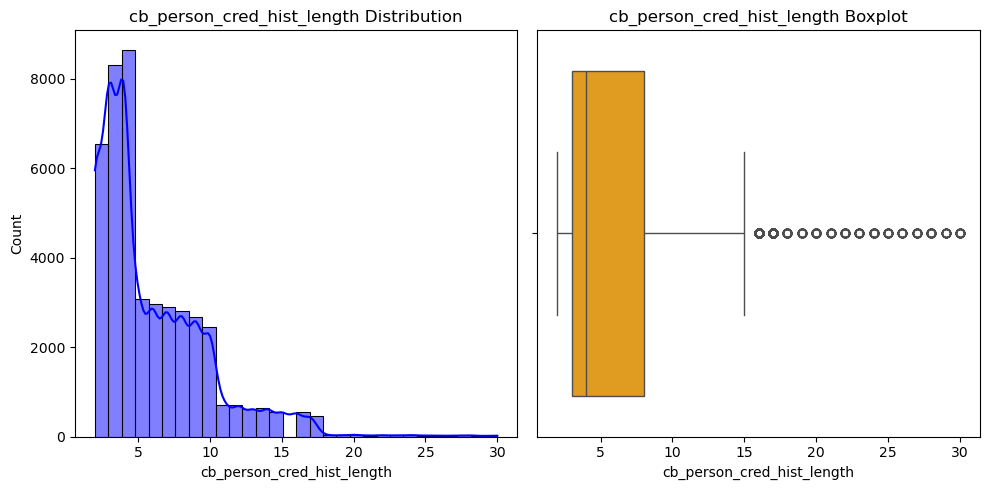

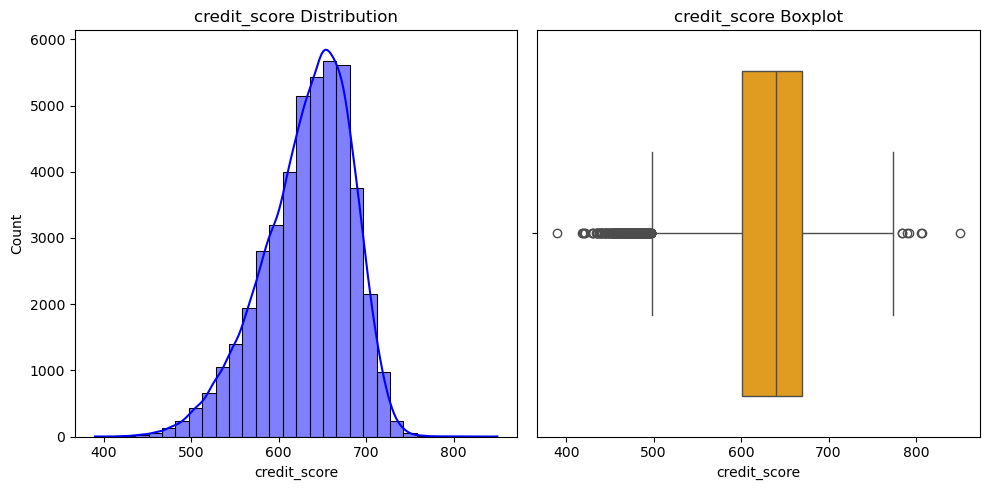

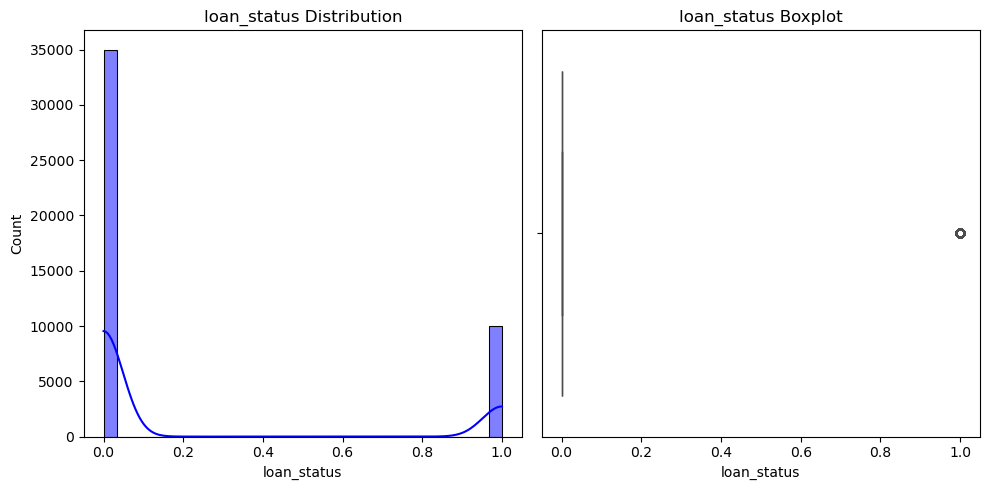

In [10]:
# Visualizing data distributions
print("\nCreating histograms and boxplots for numerical features")
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, bins=30, color='blue')
    plt.title(f'{column} Distribution')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='orange')
    plt.title(f'{column} Boxplot')

    plt.tight_layout()
    plt.show()


Visualizing categorical features


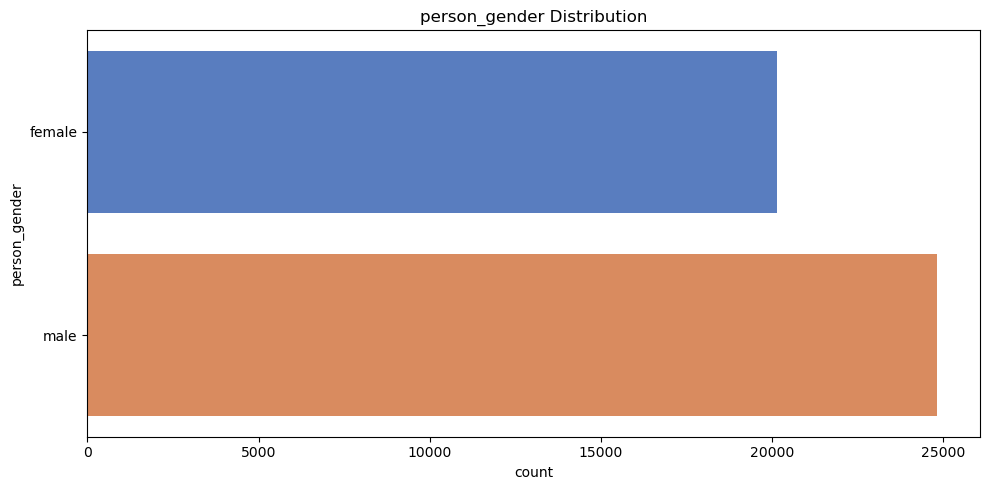

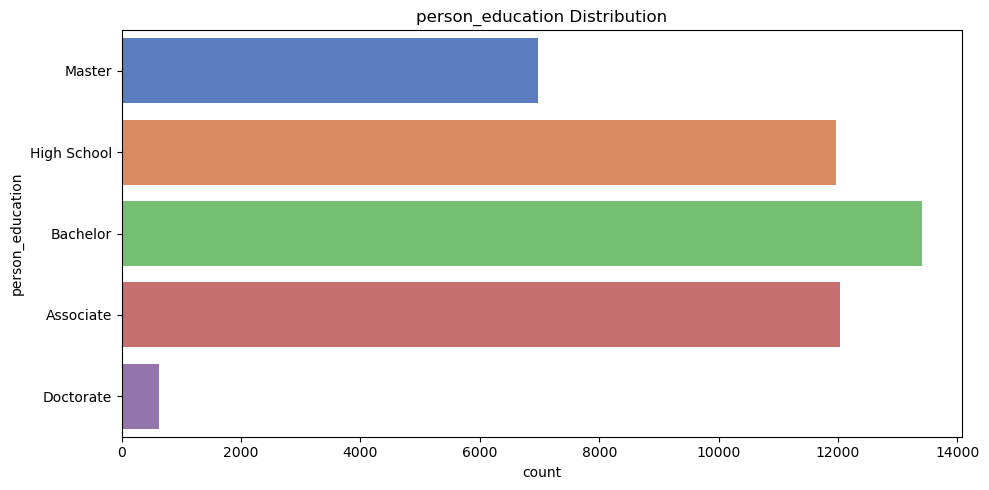

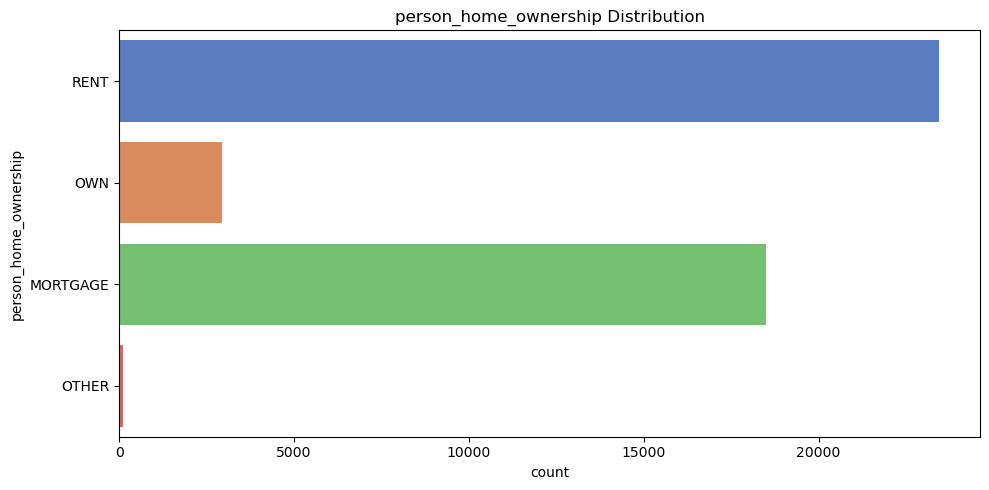

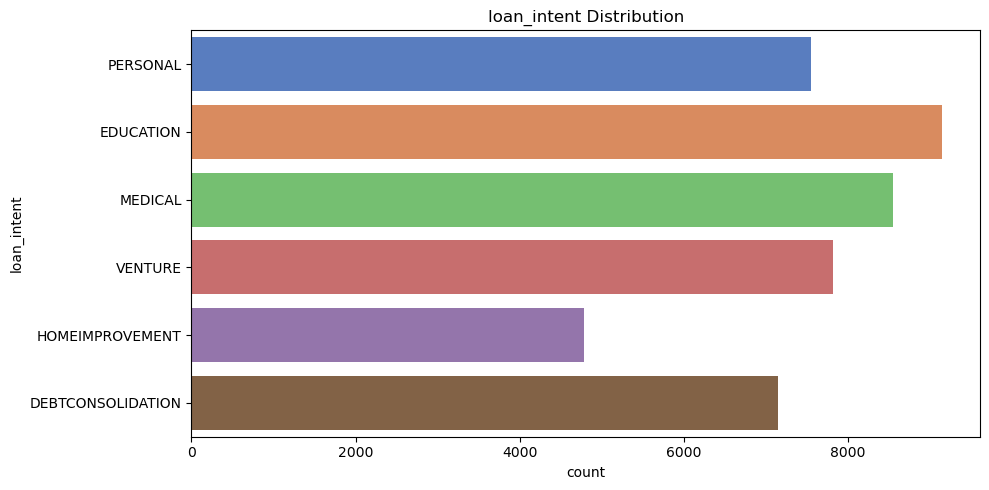

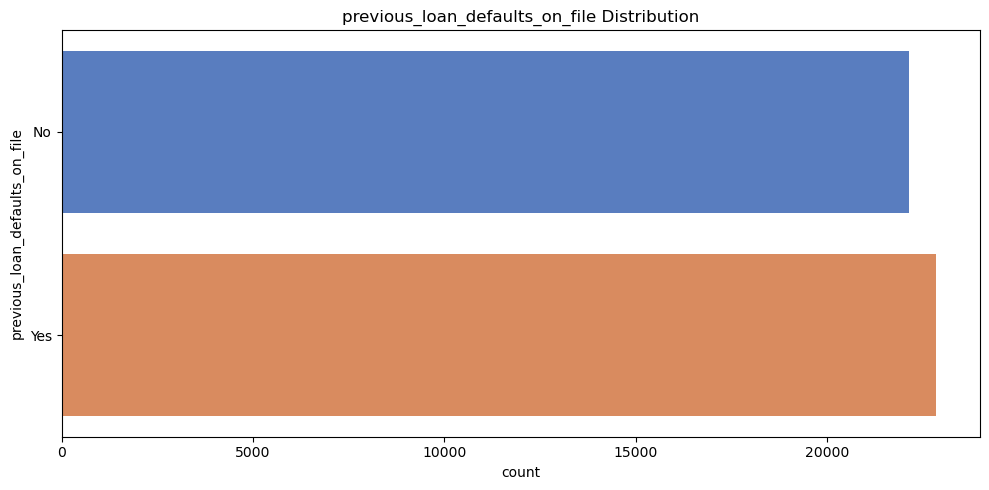

In [11]:
# Visualizing categorical feature distributions
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nVisualizing categorical features")
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=data[column], palette='muted')
    plt.title(f'{column} Distribution')
    plt.tight_layout()
    plt.show()

In [12]:
# Splitting the dataset

X = data.drop(columns=['loan_status'])
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


Splitting the dataset into training and testing sets


In [16]:
print('X_train', X_train.shape )
print('X_test,', X_test.shape )
print('y_train', y_train.shape )
print('y_test', y_test.shape )

X_train (36000, 13)
X_test, (9000, 13)
y_train (36000,)
y_test (9000,)


In [17]:
# Defining preprocessing pipelines

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object']))
    ]
)


Defining preprocessing pipelines


In [21]:
# Defining models

random_forest = RandomForestClassifier(random_state=42)
ada_boost = AdaBoostClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lightgbm = LGBMClassifier(random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf', random_forest), ('ab', ada_boost), ('gb', gradient_boosting), 
                ('xgb', xgboost), ('lgb', lightgbm), ('cat', catboost)],
    voting='soft'
)

In [20]:
# Creating the pipeline

model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', voting_clf)
])

In [22]:
# Training the model

model_pipeline.fit(X_train, y_train)


Training the model
[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1215
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015DD278B680>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oneh...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lgb',
                                               LGBMClassifier(random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x0000015DD1F6F500>)],
                                  voting='soft'))])

In [23]:
# Evaluating the model
print("\nEvaluating the model")
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Evaluating the model

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7000
           1       0.90      0.79      0.84      2000

    accuracy                           0.93      9000
   macro avg       0.92      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000


ROC-AUC Score: 0.9789049285714285

Confusion Matrix:
[[6824  176]
 [ 411 1589]]


The model performs well in predicting loan approvals and denials. Here's a breakdown of the performance:

 - Precision is high for loan denials (0.94) and good for approvals (0.90), meaning the model is reliable when it makes predictions.

 - Recall is very good for loan denials (0.97) but lower for approvals (0.79), meaning it misses some approvals.

 - The F1-score shows strong performance for denials (0.96) and decent for approvals (0.84).

 - Accuracy is 93%, indicating overall good performance.

 - The ROC-AUC score of 0.98 suggests excellent ability to distinguish between loan approvals and denials.
 
 - The confusion matrix shows the model is great at denying loans correctly (6824 true negatives) but misses some approvals (411 false negatives), while it incorrectly approves a small number (176 false positives).

In short, the model is effective at denying loans but could improve in identifying loan approv

In [ ]:
# Cross-validation scores

cross_val_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy: {cross_val_scores.mean():.2f} (+/- {cross_val_scores.std():.2f})")


Performing cross-validation
[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763


In [ ]:

model_file = 'loan_approval_model.pkl'
joblib.dump(model_pipeline, model_file)
print(f"Model saved as {model_file}")